In [1]:
from bs4 import BeautifulSoup
import json
import requests
import pandas as pd
import numpy as np
import re #regex
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from utils.tools import replace_all, extract_course_catalog 

In [2]:
department = {'ANTH','BIOI','BIOL','CHEM','CHIN','CLAS','CCS','COGS','COMM','CGS','CAT','DSC','DSGN','DOC','ECON','EDS','ENG','BENG','CSE','ECE','MAE','NANO','SE','ENVR','ESYS','ETHN','FMPH','FILM','GLBH','HIST','HDS','HR','HUM','INTL','JAPN','JWSP','LATI','LAWS','LING','LIT','MGT','MATH','MUS','PHIL','PHYS','POLI','PSYC','RELI','SCIS','SIO','SOC','THEA','TWS','USP','VIS'}

In [3]:
for dept in department: 
    names, descriptions = extract_course_catalog(dept)
    df = pd.DataFrame(columns=['Course Name', 'Course Description', 'Course Units'])
    courses = {}

    for course, description in zip(names, descriptions):
        course, description = course.getText(), description.getText()

        # Course ID check to filter upper div. classes.

        course_id = course[course.index(' ')+1:course.index('.')]

        course_name_verbose = course[course.index('.')+2:course.index('(')-1]

        # Course description w/o extra section  
        try:
            if description.index("Prerequisites:"):
                course_desc_verbose = description[:description.index("Prerequisites:")]
            else: #for other text
                course_desc_verbose = description[:description.index("Note:")]
        except ValueError:
            course_desc_verbose = description
        
        while course_id[-1].isalpha() or course_id[-1] == '-':
            course_id = course_id[:-1]

        course_id = int(re.findall(r'\d+', course_id)[0])
        if course_id >= 200:
            continue

        # Grabs course info.
        course = course.replace(":",".")
        course_name = course[:course.index('.')]
        cleaned = []
        if "Prerequisites:" in description:
            prereqs = description.split("Prerequisites:",1)[1]
            for i, char in enumerate(prereqs):
                if char == "." or char ==";":
                    prereqs = prereqs[:i]

            prereqs_list = prereqs.split(" ")
        
            encounter =False
            
            prereqs_list = [x for x in prereqs_list if x != '']
            for i, word in enumerate(prereqs_list):
                word = replace_all([',',')','\n','\t'], word)
                if word in department:
                    cleaned.append(word + " "+ replace_all([',',')','\n','\t'], prereqs_list[i+1]))
                    encounter = True
                elif word == "or" and encounter:
                    if prereqs_list[i+1] in department:
                        cleaned.append('or')
                    encounter = False
                elif word == "and":
                    cleaned.append('and')
                    if len(cleaned) == 1:
                        cleaned.remove("and")

            if len(cleaned) >0 and cleaned[-1] == 'or':
                cleaned.pop()

        #courses[course_name] = cleaned #old version
        courses[course_name] = {"prerequisites":cleaned, "name": course_name_verbose, "description": course_desc_verbose}
        course_title = course[course.index('.')+1:course.index('(')-1]
        course_units = course[course.index('('):course.index(')')+1]

        # Append row to data frame.
        df = df.append({
            'Course Name': course_name,
            'Course Description': description,
            'Course Units': course_units,
            'Prereqs': cleaned
        }, ignore_index=True)

        with open('./json/'+dept+'.json','w') as fp:
            json.dump(courses,fp,indent=4)

In [22]:
"<p class=\"course-name\">VIS 21B. Introduction to Asian Art (4)</p>" in [str(i) for i in names] 

True

In [61]:
#merging into a master json
master_dict = {}
for dept in department:
    try:
        dept_dict = json.load(open('./json/' + dept + '.json'))
        master_dict.update(dept_dict)
    except FileNotFoundError:
        print('bad: ', dept)

with open('./json/master_prereqs.json','w') as fp:
    json.dump(master_dict,fp,indent=4)

bad:  HR


In [8]:
def create_graph(edges, parse_course, start):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    short_path = nx.shortest_path(G, source=start, target=parse_course)
    new_path = []
    for i, snode in enumerate(short_path):
        try:
            new_path.append((snode,short_path[i+1]))
        except:
            break
    colors = []
    for node in G.nodes():
        if node == parse_course:
            colors.append("Green")
        else:
            colors.append("Grey")
        
    plt.figure(3,figsize=(12,12))
    F = nx.DiGraph()
    F.add_edges_from(new_path)
    #nx.draw(F, with_labels=True, width = 3, node_size = 1500) #UNCOMMENT FOR SHORTEST PATH
    nx.draw(G, with_labels=True, node_color = colors, width = 3, node_size = 1500)
    plt.show()

What class: MATH 103A


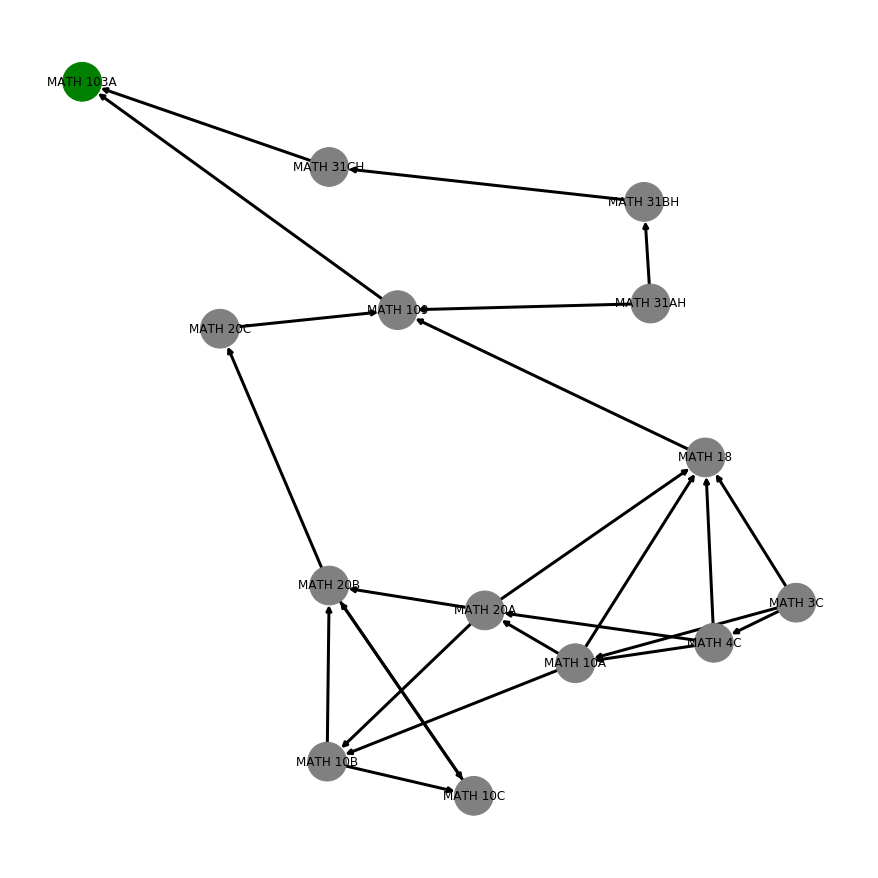

In [9]:
def runner(parse_course, edge_list, created, starting):
    created.append(parse_course)
    if parse_course in courses:
        if not courses[parse_course]:
            starting.append(parse_course)
        for course in courses[parse_course]:
            if course != 'or' and course != 'and' and course in courses.keys():
                edge_list.append((course,parse_course))
                if course not in created:
                    runner(course, edge_list, created, source)
            
already_created = []
edges = []
source= []
test1 = input("What class: ")
runner(test1, edges, already_created, source)
create_graph(edges, test1, source[0])

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 9 missing from current font.

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 9 missing from current font.



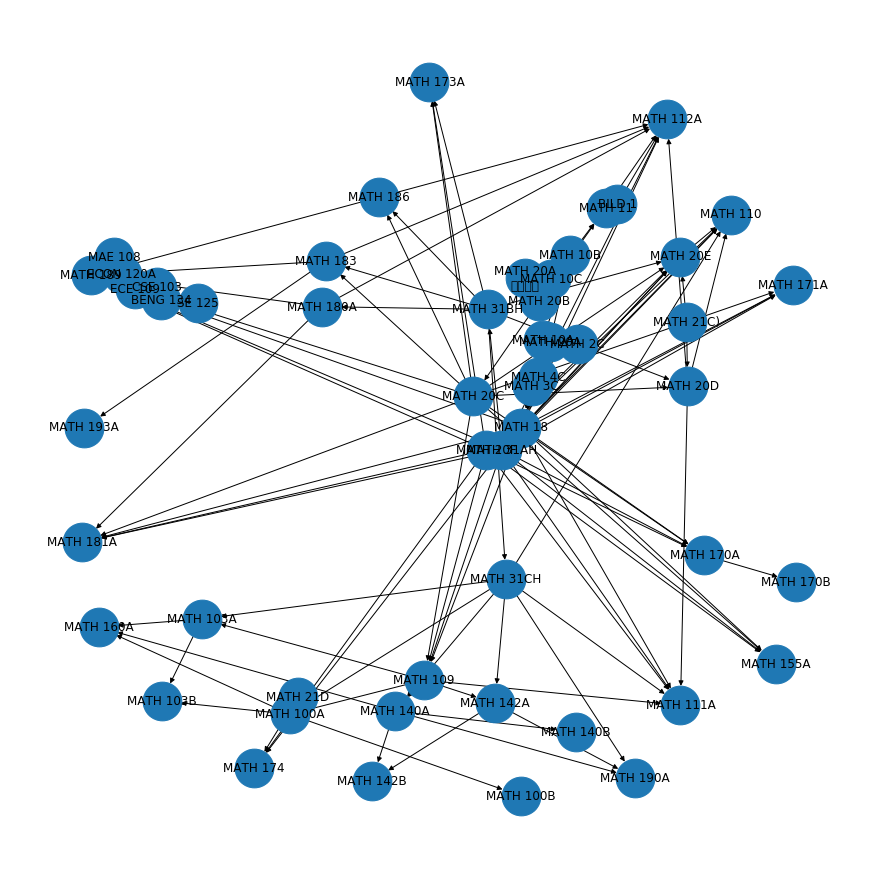

In [9]:
new_edges = []
already_made = []
for key in courses.values():
    for seq in key:
            runner(seq,new_edges,already_made)
            
G = nx.DiGraph()
G.add_edges_from(new_edges)
plt.figure(3,figsize=(12,12))
nx.draw(G, with_labels=True, node_size = 1500)
plt.show()